# Testing

## Intro

<img width="600" src="images/iiit5k.png">
<p>In this notebook, the model is tested on the <a href="https://cvit.iiit.ac.in/projects/SceneTextUnderstanding/IIIT5K.html">IIIT 5K-word dataset</a> without any fine-tuning. Unlike the training dataset that was automatically generated, this one contains actual real-world images with text.</p>

## Import dependencies

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tools import plot_images

import sys
sys.path.insert(0, "..")
import datasets
import vit

%matplotlib inline

## Load the dataset

To load dataset, you need to specify the path to it:

In [2]:
dataset_path = "/home/oleg/.keras/datasets/IIIT5K"
train_ds, test_ds = datasets.load_iiit5k(dataset_path)

A hash table to map numeric labels to characters:

In [3]:
labels = tf.range(len(datasets.IIIT5K_CHARS))
label_to_char = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(labels, datasets.IIIT5K_CHARS), "")

Let's plot some images from the dataset. All images were resized to 32x100 pixels to match the shape of images that were used for training.

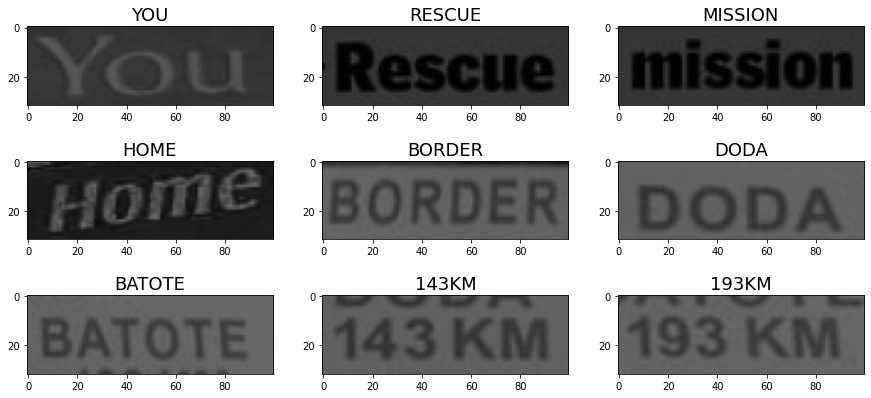

In [4]:
images = [(image.numpy() + 1) / 2 for image, _ in train_ds.take(9)]
texts = ["".join(c.decode("UTF-8") for c in label_to_char.lookup(text_labels).numpy())
         for _, text_labels in train_ds.take(9)]

plt.figure(figsize=(15, 7))
plot_images(images, texts, rows=3, columns=3)

Shuffle, batch and prefetch the dataset:

In [7]:
BATCH_SIZE = 256
LABELS_PADDING_CONST = -1

def configure_for_performance(dataset):    
    dataset = dataset.padded_batch(
        BATCH_SIZE,
        padding_values=(None, LABELS_PADDING_CONST),
        padded_shapes=(
            [datasets.IMAGE_HEIGHT, datasets.IMAGE_WIDTH, datasets.IMAGE_CHANNELS],
            [None],)
        )
    
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

train_ds = configure_for_performance(train_ds)
test_ds = configure_for_performance(test_ds)

Unlike the training dataset, the IIIT5K doesn't differentiate between upper and lower case letters, so a special wrapper function around the CTCAccuracy is required to handle this:

In [8]:
def get_accuracy(model, dataset):
    accuracy = vit.metrics.CTCAccuracy()
    for X, y_true in dataset:
        y_pred = model.predict(X)
        y_pred = y_pred.argmax(axis=-1)
        y_pred[y_pred >= 36] -= 26
        y_pred = tf.one_hot(y_pred, 37)
        accuracy.update_state(y_true, y_pred)
    return accuracy.result().numpy()

Load the trained model:

In [9]:
model = tf.keras.models.load_model("saved_model")

Evaluate the model on the train part of the IIIT5K dataset:

In [10]:
get_accuracy(model, train_ds)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


0.8875

Evaluate the model on the test part of the IIIT5K dataset:

In [11]:
get_accuracy(model, test_ds)

0.8096667

<p>Since the model wasn't fine-tuned on the IIIT5K dataset, both the train and the test parts of this dataset can be used to evaluate the model. And it is quite interesting that performance of the model on the train part is significantly better than on the test part, which means that those parts of the IIIT5K dataset might not be equally "hard". However, to be consistent with other models, only performance on the test part should be considered.</p>

<p>So, achieving <b>80.97%</b> accuracy, the model is on par with some older models like the CRNN, but is far from the current state of the art results.</p>